In [1]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [2]:
from FBSNNs import *
from BlackScholesBarenblatt100D import *

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 100  # number of trajectories (batch size)
N = 50  # number of time snapshots
D = 100 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0, 0.5] * int(D / 2))[None, :]
T = 1.0

"Available architectures"
mode = "Naisnet"  # FC and Naisnet are available
activation = "Sine"  # Sine, ReLU and Tanh are available
model = BlackScholesBarenblatt(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10**4
lr = 1e-2

In [4]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 0, Loss: 5.439e+05, Y0: -0.055, Time: 0.91, Learning Rate: 1.000e-02
It: 100, Loss: 5.743e+05, Y0: 16.698, Time: 13.17, Learning Rate: 1.000e-02
It: 200, Loss: 4.991e+05, Y0: 28.105, Time: 9.38, Learning Rate: 1.000e-02
It: 300, Loss: 3.502e+05, Y0: 33.701, Time: 5.95, Learning Rate: 1.000e-02
It: 400, Loss: 5.610e+05, Y0: 32.635, Time: 2.43, Learning Rate: 1.000e-02
It: 500, Loss: 5.863e+05, Y0: 25.434, Time: 2.16, Learning Rate: 1.000e-02
It: 600, Loss: 3.175e+05, Y0: 37.999, Time: 2.35, Learning Rate: 1.000e-02
It: 700, Loss: 2.507e+05, Y0: 39.637, Time: 2.08, Learning Rate: 1.000e-02
It: 800, Loss: 3.515e+05, Y0: 28.410, Time: 2.14, Learning Rate: 1.000e-02
It: 900, Loss: 5.193e+05, Y0: 12.485, Time: 2.33, Learning Rate: 1.000e-02
It: 1000, Loss: 4.713e+05, Y0: 30.575, Time: 2.16, Learning Rate: 1.000e-02
It: 1100, Loss: 3.106e+05, Y0: 39.884, Time: 2.39, Learning Rate: 1.000e-02
It: 1200, Loss: 5.662e+05, Y0: 26.162, Time: 2.20, Learning Rate: 1.000e-02
It: 1300, Loss: 

In [11]:
n_iter = 41 * 10**2
lr = 1e-5

In [5]:
model.load_model("models/BlackScholesBarenblattMLMC100DRMSProp.pth")

In [5]:
graph = model.iteration, model.training_loss

In [6]:
def figsize(scale, nplots = 1):
    fig_width_pt = 438.17227                        
    inches_per_pt = 1.0/72.27                       
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            
    fig_width = fig_width_pt*inches_per_pt*scale    
    fig_height = nplots*fig_width*golden_mean             
    fig_size = [fig_width,fig_height]
    return fig_size

In [7]:
np.random.seed(65)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)
samples = 5

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

Y_test = np.reshape(u_exact(T,np.reshape(t_test[0:M, :, :], [-1, 1]), np.reshape(X_pred[0:M, :, :], [-1, D])),
                    [M, -1, 1])

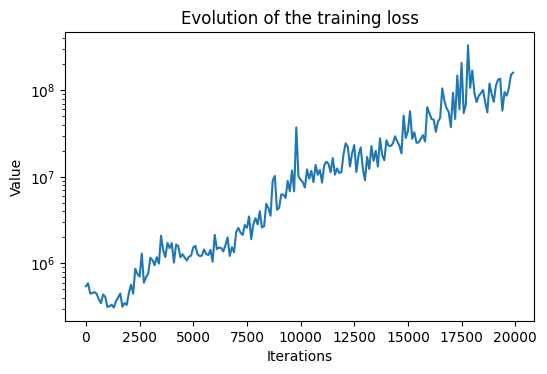

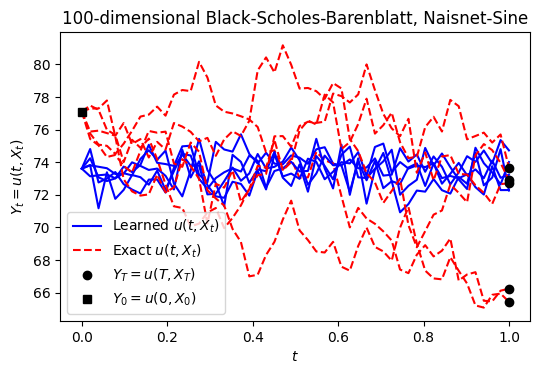

In [8]:
plt.figure(figsize=figsize(1))
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
# plt.savefig('Figures/BlackScholesBarenblattMLMC100DLoss1000.pdf')

plt.figure(figsize=figsize(1))
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0:1, :, 0].T, Y_test[0:1, :, 0].T, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0:1, -1, 0], Y_test[0:1, -1, 0], 'ko', label='$Y_T = u(T,X_T)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T, 'b')
plt.plot(t_test[1:samples, :, 0].T, Y_test[1:samples, :, 0].T, 'r--')
plt.plot(t_test[1:samples, -1, 0], Y_test[1:samples, -1, 0], 'ko')

plt.plot([0], Y_test[0, 0, 0], 'ks', label='$Y_0 = u(0,X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()
# plt.savefig('Figures/BlackScholesBarenblattMLMC100DPreds1000.pdf')

plt.show()

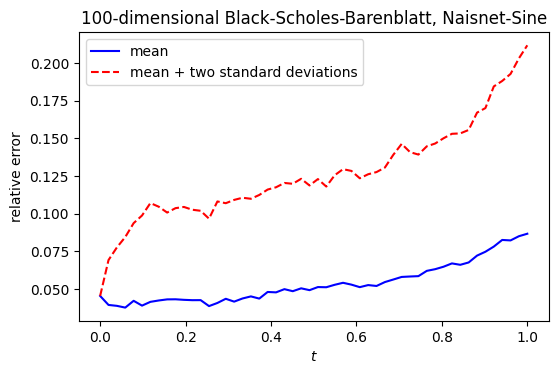

In [9]:
errors = np.sqrt((Y_test - Y_pred) ** 2 / Y_test ** 2)
mean_errors = np.mean(errors, 0)
std_errors = np.std(errors, 0)
plt.figure(figsize=figsize(1))
plt.plot(t_test[0, :, 0], mean_errors, 'b', label='mean')
plt.plot(t_test[0, :, 0], mean_errors + 2 * std_errors, 'r--', label='mean + two standard deviations')
plt.xlabel('$t$')
plt.ylabel('relative error')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()
# plt.savefig('Figures/BlackScholesBarenblattMLMC100DErrors1000.pdf')
plt.show()

In [10]:
model.save_model("models/BlackScholesBarenblattMLMC100DRMSProp.pth")